# Neural Networks with Tensorflow

We are going to train a Neural Networks on the Japanese MNIST dataset. It is composed of 70000 images of handwritten Hiragana characters. The target variables has 10 different classes.

Each image is of dimension 28 by 28. But we will flatten them to form a dataset composed of vectors of dimension (784, 1). The training process will be similar as for a structured dataset.

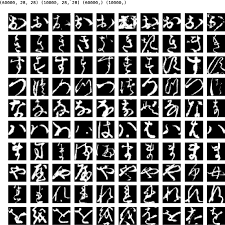



# 1. Import Required Packages

[1.1] We are going to use numpy, matplotlib and google.colab packages

In [ ]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt

# 2. Download Dataset

We will store the dataset into your personal Google Drive.


[2.1] Mount Google Drive

In [ ]:
# Mount Google Drive to access data
drive.mount('/content/gdrive')

[2.2] Create a folder called `DL_ASG_1` on your Google Drive at the root level

In [ ]:
# Create necessary directory in Google Drive
! mkdir -p /content/gdrive/MyDrive/DL_Projects

[2.3] Navigate to this folder

In [ ]:
# Change current working directory to the project folder
! cd /content/gdrive/MyDrive/DL_Projects

[2.4] Dowload the dataset files to your Google Drive if required

In [ ]:
import requests
from tqdm import tqdm
import os.path

def download_file(url):
    """
    Download file from URL if not already downloaded.

    Parameters:
        url (str): URL of the file to download.
    """
    path = url.split('/')[-1]
    if os.path.isfile(path):
        print(f"{path} already exists")
    else:
        r = requests.get(url, stream=True)
        with open(path, 'wb') as f:
            total_length = int(r.headers.get('content-length'))
            print('Downloading {} - {:.1f} MB'.format(path, (total_length / 1024000)))
            for chunk in tqdm(r.iter_content(chunk_size=1024), total=int(total_length / 1024) + 1, unit="KB"):
                if chunk:
                    f.write(chunk)

# List of URLs to download the KMNIST dataset
url_list = [
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-imgs.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-train-labels.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-imgs.npz',
    'http://codh.rois.ac.jp/kmnist/dataset/kmnist/kmnist-test-labels.npz'
]

# Download the KMNIST dataset files
for url in url_list:
    download_file(url)

[2.5] List the content of the folder and confirm files have been dowloaded properly

In [ ]:
! ls

# 3. Load Data

[3.1] Import the required modules from Tensorflow

In [ ]:
# Import necessary packages
# Note: Removed duplicated imports and organized them
import os
import pandas as pd
import seaborn as sns
from IPython.display import SVG
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras import backend as K
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tqdm import tqdm_notebook

[3.2] Create 2 variables called `img_height` and `img_width` that will both take the value 28

In [ ]:
#set the image dimensions 28
IMG_HEIGHT = 28
IMG_WIDTH = 28



[3.3] Create a function that loads a .npz file using numpy and return the content of the `arr_0` key

In [ ]:
def load_data(f):
    """
    Load data from the given npz file.

    Parameters:
        f (str): File path of the npz file.

    Returns:
        numpy.ndarray: Loaded data from the npz file.
    """
    return np.load(f)['arr_0']


[3.4]  Load the 4 files saved on your Google Drive into their respective variables: x_train, y_train, x_test and y_test

In [ ]:
# Load the KMNIST data
x_train = load_data('kmnist-train-imgs.npz')
x_test = load_data('kmnist-test-imgs.npz')
y_train = load_data('kmnist-train-labels.npz')
y_test = load_data('kmnist-test-labels.npz')

print("KMNIST train shape:", x_train.shape)
print("KMNIST test shape:", x_test.shape)
print("KMNIST train shape:", y_train.shape)
print("KMNIST test shape:", y_test.shape)


[3.5] Using matplotlib display the first image from the train set and its target value

In [ ]:
# Plot the first image from the train set
plt.title(y_train[0])
plt.imshow(x_train[0], cmap="Greys")
plt.show()


In [ ]:
# Function to plot sample images for each class
def plot_sample_images_data(images, labels):
    """
    Plot sample images for each class.

    Parameters:
        images (numpy.ndarray): Array of images.
        labels (numpy.ndarray): Array of labels.
    """
    plt.figure(figsize=(12, 12))
    for i in tqdm_notebook(range(10)):
        imgs = images[np.where(labels == i)]
        lbls = labels[np.where(labels == i)]
        for j in range(10):
            plt.subplot(10, 10, i * 10 + j + 1)
            plt.xticks([])
            plt.yticks([])
            plt.grid(False)
            plt.imshow(imgs[j], cmap="Greys")
            plt.xlabel(lbls[j])

plot_sample_images_data(x_train, y_train)

# 4. Prepare Data

[4.1] Reshape the images from the training and testing set to have the channel dimension last. The dimensions should be: (row_number, height, width, channel)

In [ ]:
# Flatten the image data and normalize it
x_train = x_train.reshape((x_train.shape[0], IMG_HEIGHT * IMG_WIDTH))
x_test = x_test.reshape((x_test.shape[0], IMG_HEIGHT * IMG_WIDTH))


[4.2] Cast `x_train` and `x_test` into `float32` decimals

In [ ]:
#change the data type and make sure that the value are float
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

[4.3] Standardise the images of the training and testing sets. Originally each image contains pixels with value ranging from 0 to 255. after standardisation, the new value range should be from 0 to 1.

[4.4] Create a variable called `num_classes` that will take the value 10 which corresponds to the number of classes for the target variable

In [ ]:
# Set the number of classes
NUM_CLASSES = 10

[4.5] **TODO** Convert the target variable for the training and testing sets to a binary class matrix of dimension (rows, num_classes).

For example:
- class 0 will become [1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
- class 1 will become [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
- class 5 will become [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
- class 9 will become [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [ ]:
# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

# 5. Define Neural Networks Architecure

[5.1] Set the seed for Tensorflow Keras






In [ ]:
# Set random seed for reproducibility
keras.utils.set_random_seed(42)

[5.2]  Define the architecture of your Neural Networks and save it into a variable called `model`

In [ ]:
# Create the Sequential model
model = Sequential()
model.add(Dense(256, input_shape=(IMG_HEIGHT * IMG_WIDTH,), activation="sigmoid"))
model.add(Dropout(0.5))
model.add(Dense(128, activation="sigmoid"))
model.add(Dense(NUM_CLASSES, activation="softmax"))

[5.2] Print the summary of your model

In [ ]:
# Display the model summary
model.summary()

# 6. Train Neural Networks

[6.1]  Create 2 variables called `batch_size` and `epochs` that will  respectively take the values 128 and 500

In [ ]:

# Set up training parameters
BATCH_SIZE = 128
EPOCHS = 500




[6.2]  Compile your model with the appropriate loss function, the optimiser of your choice and the accuracy metric

In [ ]:
# Compile the model
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])


[6.3]  Fit your model using the number of epochs defined. SAve the ouput to a variable called `history`. You can set up some callbacks if you wish.

In [ ]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

[6.4] Save the weights of your model

In [ ]:
# Save the model weights
model.save_weights('./checkpoints/my_checkpoint')


# 7. Analyse Results

[7.1] Display the performance of your model on the training and testing sets

In [ ]:
# Evaluate the model
train_score = model.evaluate(x_train, y_train, verbose=2)
test_score = model.evaluate(x_test, y_test, verbose=2)
print('Train loss:', train_score[0])
print('Train accuracy:', train_score[1])
print('Test loss:', test_score[0])
print('Test accuracy:', test_score[1])

[7.2]  Plot the learning curve of your model

In [ ]:

# Plot the training loss and accuracy
plt.plot(np.arange(0, EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), history.history['val_accuracy'], label='val_acc')
plt.title("Training Loss and Accuracy")
plt.ylabel('Loss / Accuracy')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.show()


[7.3]  Display the confusion matrix on the testing set predictions

In [ ]:
print("[INFO] evaluating network...")
# Evaluate the network
predictions = model.predict(x_test, batch_size=BATCH_SIZE)
predictions_argmax = predictions.argmax(axis=1)
y_true_argmax = y_test.argmax(axis=1)
print(classification_report(y_true_argmax, predictions_argmax))


In [ ]:
# Get correctly and incorrectly predicted classes
correct = np.nonzero(predictions_argmax == y_true_argmax)[0]
incorrect = np.nonzero(predictions_argmax != y_true_argmax)[0]

print("Correct predicted classes:", correct.shape[0])
print("Incorrect predicted classes:", incorrect.shape[0])

In [ ]:
def plot_images(data_index, cmap="Blues"):
    """
    Plot images with true and predicted labels.

    Parameters:
        data_index (numpy.ndarray): Array of data indices.
        cmap (str): Colormap for the images.
    """
    # Plot the sample images now
    f, ax = plt.subplots(5, 5, figsize=(12, 12))

    for i, indx in enumerate(data_index[:25]):
        ax[i // 5, i % 5].imshow(x_test[indx].reshape(IMG_HEIGHT, IMG_WIDTH), cmap=cmap)
        ax[i // 5, i % 5].axis('off')
        ax[i // 5, i % 5].set_title("True:{}  Pred:{}".format(y_true_argmax[indx], predictions_argmax[indx]))
    plt.show()


In [ ]:
plot_images(correct, "Greens")

In [ ]:
plot_images(incorrect, "Reds")

In [ ]:
# Create the confusion matrix
confusion_mat = tf.math.confusion_matrix(y_true_argmax, predictions_argmax)

# Plot the confusion matrix heatmap
plt.figure(figsize=(15, 7))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()